# O Problema

Temos no CEFET MG o grupo Grupo de Computação Competitiva (GCC) que tem como uma de suas atividades a participação na maratona de programação.

A maratona de programação é uma competição onde equipes competem entre si em um período de tempo pré determinado a tentar resolver o maior número de problema em menos tempo.

O objetivo deste trabalho, é desenvolver um algoritmo de recomendação que ajude no treinamento dos competidores para a preparação para a maratona de programação.

Atualmente, o treinamento funciona da seguinte maneira. Existem alguns sites, chamados de juízes online, que funcionam como um repositório de problemas. O competidor então consegue ler o problema, desenvolver uma solução e submete-la para o juiz. O juiz então dará a resposta se a solução foi aceita ou não.

O problema do treinamento atual é que existem milhares de problemas a serem resolvidos. Isso faz com que o competidor perca tempo em problemas que não acrescentem em conteúdo para o seu desenvolvimento, ou então, escolha problemas muito difíceis para serem resolvidos, o que torna seu treinamento desmotivador.

# Introdução

Neste capítulo, será descrito em detalhes, a fase de coleta de dados, definição e treinamento do modelo e implementação da solução proposta.



# Dataset

## A fonte

A primeira decisão a ser tomada foi na escolha de qual juiz online utilizar como fonte de informações. Algumas considerações foram feitas a fim de decidir o juiz, dentre elas:

 - O juiz a ser escolhido deve ser frequentemente utilizado pelos alunos do GCC, uma vez que são os principais usuários do sistema.
 - O juiz deve possuir informações relevantes sobre os problemas em seu repositório, como dificuldade e categoria que será utilizado posteriormente como forma de validação do modelo.
 - O juiz deve possuir um número quantitativamente relevante para a coleta.
 - O juiz deve permitir a coleta das informações.
 
Os critérios definidos levaram a escolha do URI Online Judge. O URI é o juiz com mais problemas resolvidos pelos alunos do GCC, como pode ser visto no BANG. Seus problemas possuem nível de dificuldade, categoria, número de usuários únicos que o resolveram e em alguns problemas, é possível obter até o assunto que o problema aborda dentro daquela categoria. No ano de 2017, o URI atingiu a marca de 1656 problemas, 195329 usuários de 170 países e 7956566 submissões, como pode ser visto em (https://www.urionlinejudge.com.br/year-in-numbers/2017/2/). Todas essas informações são públicas e podem ser vistas no próprios site.

## As informações

Com o juiz definido, o próximo passo foi definir o que e o quanto de informações seriam adquiridas do juiz.

No URI, cada usuário possui uma página de perfil que informa quando e quais problemas o usuário resolveu. Cada registro dessa página é conhecido como **solução**. Além dos perfis de usuários, existe também a página de problemas, onde é possível encontrar informações detalhadas de cada problema, como categoria, dificuldade e número usuários que conseguiram resolver o problema.

Dessa forma, através das informações dos usuários e a descrição dos problemas, foi possível construir um dataset composto por um conjunto de soluções, onde cada solução é composta por:

 - **user_id**: usuário que resolveu o problema
 - **problem_id**: problema que foi resolvido
 - **date**: data de quando o problema foi resolvido
 - **category_id**: categoria do problema resolvido
 - **level**: dificuldade do problema resolvido
 - **solved**: quantidade total de usuários únicos do juiz que resolveram o problema
 - **name**: nome do problema
 - **topics**: assuntos relacionados ao conteúdo do problema
 
Foi então coletado, as informações de todos os usuários que haviam resolvido pelo menos 300 problemas, cerca de 20% do número total de problemas disponíveis no juiz. A coleta resultou em um conjutno de soluções com 618 usuários e 218619 soluções.

In [443]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import spatial
from sklearn.cluster import KMeans
from datetime import datetime
from pprint import pprint
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
from numpy.random import rand
from glob import glob

# Configurações

In [602]:
# 0 - All
# 1 - Beginner
# 2 - Ad-Hoc
# 3 - String
# 4 - Libraries
# 5 - Math
# 6 - Paradigms
# 7 - Graph
# 8 - Geometry

COLORS = [
    '',
    '#0F5B78',
    '#117899',
    '#1496BB',
    '#5CA794',
    '#A3B86C',
    '#EBC944',
    '#F26D21',
    '#D94E20',
    '#C02F1D',
]


CATEGORY = 5
NR_FEATURES = 2
NR_EPOCHS = 20
NR_ITERATIONS = 2000

In [603]:
def load_solutions():
    solutions_df = pd.read_csv('solutions_uri.csv')
    if CATEGORY:
        solutions_df = solutions_df.loc[solutions_df['category_id'] == CATEGORY]
        solutions_df = solutions_df.loc[solutions_df['solved'] > 100]
#         solutions_df = solutions_df.loc[solutions_df['topics'].str.contains('dfs')]
    return solutions_df

Dataset overview

In [604]:
solutions_df = load_solutions()
solutions_df[:5]

,user_id,problem_id,date,category_id,level,solved,name,topics
58,40980,1169,15/04/19 03:43,5,1,3595,Grains in a Chess Board,simple math
75,40980,1233,15/10/06 01:35,5,6,537,Star,"math, numbers theory"
76,40980,1989,15/11/28 06:17,5,4,197,Doing Nothing,unknown
80,40980,1760,15/09/04 08:44,5,1,700,Koch Snowflake,-
83,40980,1163,15/08/28 11:14,5,5,589,Angry Ducks,math


Quantidade de soluções do dataset:

In [605]:
len(solutions_df)

20444

Quantidade de problemas do dataset:

In [606]:
solutions_df['problem_id'].nunique()

105

Quantidade de usuários do dataset:

In [607]:
solutions_df['user_id'].nunique()

617

Quantidade de categorias do dataset:

In [608]:
solutions_df['category_id'].nunique()

1

# Modelo

## Considerações iniciais


O aprendizado é um processo gradativo, por se realizar por meio de operações crescentemente complexas. A cada aprendizagem novos elementos são acrescidos às experiências anteriores em dimensão gradativa e ascendente. Também se caracteriza por ser um processo cumulativo, visto que a experiência de aprendizagem atual utiliza-se das experiências anteriores. [(SANTANA, 2014)](http://producao.virtual.ufpb.br/books/edusantana/fundamentos-psicologicos-da-educacao-livro/livro/livro.chunked/ch06s03.html)

Tal como as aulas de cálculo, onde começamos pelo o estudo de funções, passamos por limites e derivadas até finalmente o estudo das integrais. Da mesma forma acontece o treinamento para a maratona de programação. Por exemplo, no estudo de estruturas de dados, iniciamos com o estudo de estruturas de dados simples como pilhas e filas, seguido por estruturas como árvores e grafos até chegarmos em estruturas de dados complexas como a Segment Tree.

Baseado nas informações acima citadas, podemos concluir que um competidor para resolver um problema mais complexo, necessita desenvolver conhecimentos fundamentais. E a partir desta conclusão temos o primeiro problema a ser resolvido por este trabalho: **Identificar os tópicos necessários a se saber para a solução de um problema**

Tendo isso em mente, essa será a primeira tarefa desenvolvida. Para isso iremos utilizar a técnica de Collaborative Filtering.


## Colaborative Filtering

> A Colaborative Filtering é um método para fazer previsões automáticas (filtragem) sobre os interesses de um usuário, coletando preferências ou informações de gosto de muitos usuários (colaborando). O pressuposto subjacente da abordagem de filtragem colaborativa é que se uma pessoa A tiver a mesma opinião que uma pessoa B em um problema, é mais provável que a opinião de B seja diferente em relação a uma pessoa escolhida aleatoriamente. Por exemplo, um sistema de recomendação de filtragem colaborativa para os gostos da televisão poderia fazer previsões sobre o programa de televisão que um usuário deveria gostar, dado uma lista parcial dos gostos desse usuário (gosta ou não gosta).

Imagine uma situação onde temos um dataset composto por avaliações de filmes. Cada avaliação é feita através de uma nota entre 1 e 5. Teriamos uma tabela da seguinte forma:

| Filmes  | Ana | Beto | Carlos | Dani |
|---------|:---:|:----:|:------:|:----:|
| Querido John |  5  |   4  |    0   |   0  |
| Titanic |  3  |   5  |    0   |   0  |
| Batman |  0  |   0  |    4   |   5  |
| Thor |  0  |   0  |    5   |   4  |

As notas dadas aos filmes podem ser relacionadas as preferências do usuário em relação aos gêneros dos filmes. A alta nota de Beto ao filme Titanic pode ser justificada por Beto gostar de filmes de romance.

Logo, se fossem conhecidos as caraterísticas dos filmes e as preferências do usuários, poderiamos prever uma avaliação de um filme por um usuário, e com isso, conseguir sugerir o melhor filme para o usuário.

| Filme/Características | Ação | Romance |
|---------|:--:|:--:|
| Querido John | ? | ? |
| Titanic | ? | ? |
| Batman | ? | ? |
| Thor | ? | ? |


| Usuário/Preferência  | Ação | Romance |
|:--:|:-:|:--:|
| Ana | ? | ? |
| Beto | ? | ? |
| Carlos | ? | ? |
| Dani | ? | ? |


Podemos então representar cada filme com um vetor de **características** $X$ e cada usuário com um vetor de **preferências** $\theta$ ambos de mesma dimensão. A nota final do filme, pode ser então dada pelo produto $X ⋅ \theta^T$

Embora não tenhamos os valores de $X$ e $\theta$ estes valores podem ser obtidos através do nosso dataset seguindo os seguintes passos:

1. Iniciamos $X$ com valores randômicos.
2. A partir daí temos um problema de otimização, onde o nosso objetivo é encontrar os valores de $\theta$ que minimizem a diferença entre a nota do filme $f$ dado pelo usuário $u$ pelo produto $ X_u \cdot \theta_f^T $.
3. Repetimos o procedimento 2, porém com o objetivo de encontrar os novos valores de $X$ utilizando os valores de $\theta$ encontrados. 
4. Repetimos os procedimentos 2 e 3, até encontrarmos valores estáveis de $\theta$ e $X$ ou por um número pré determinado de iterações.

In [9]:
# http://www.bogotobogo.com/python/python_numpy_batch_gradient_descent_algorithm.php
def gradient_descent(x, y, alpha=0.01, nr_iterations=NR_ITERATIONS):

    # m - number of samples
    # n - number features
    m, n = x.shape

    # insert column theta_zero = 1
    x = np.c_[ np.ones(m), x]

    theta = np.ones(n + 1)
    x_transpose = x.transpose()

    for iter in range(0, nr_iterations):
        hypothesis = np.dot(x, theta)
        loss = hypothesis - y
        J = np.sum(loss ** 2) / (2 * m)
        gradient = np.dot(x_transpose, loss) / m         
        theta = theta - alpha * gradient

    return theta

In [281]:
users_preferences = np.array([
    [rand(), rand()],
    [rand(), rand()],
    [rand(), rand()],
    [rand(), rand()],
])

movies_characteristics = [
    [None, None],
    [None, None],
    [None, None],
    [None, None],
]

ratings = [
    [5, 4, 0, 0],
    [3, 5, 0, 0],
    [0, 0, 4, 5],
    [0, 0, 5, 4],
]

ratings_t = np.transpose(ratings).tolist()

nr_users = len(users_preferences)
nr_movies = len(movies_characteristics)

i = 0
while i <= NR_EPOCHS:
    clear_output(wait=True)
    print('Progress: {}%'.format(100 * i / NR_EPOCHS))
    i += 1

    for movie in range(nr_movies):
        x = np.array(
            users_preferences
        )

        y = np.array(
            ratings[movie]
        )

        movies_characteristics[movie] = gradient_descent(x, y)[1:]


    for user in range(nr_users):
        x = np.array(
            movies_characteristics
        )

        y = np.array(
            ratings_t[user]
        )

        users_preferences[user] = gradient_descent(x, y)[1:]

Progress: 100.0%


Preferências dos usuários

In [11]:
users_preferences

array([[ 1.44824299, -0.72341461],
       [ 1.58051267, -0.8127916 ],
       [ 0.55120975,  1.7742259 ],
       [ 0.55120979,  1.7742259 ]])

Características dos filmes

In [12]:
movies_characteristics

[array([ 1.56736625, -0.83680245]),
 array([ 1.43773043, -0.74457355]),
 array([ 0.589938 ,  1.7713829]),
 array([ 0.58993779,  1.77138289])]

Com os valores de $X$ e $\theta$ em mãos, podemos então prever os votos dos usuários através do produto $X ⋅ \theta^T$

In [13]:
np.rint(np.dot(users_preferences, np.transpose(movies_characteristics))) + 2

array([[ 5.,  5.,  2.,  2.],
       [ 5.,  5.,  1.,  1.],
       [ 1.,  1.,  5.,  5.],
       [ 1.,  1.,  5.,  5.]])

# Adaptação

O conceito acima citado, foi estudado e então adaptado ao nosso problema. Primeiramente foram identificadas as características de cada problema, assim como identificamos as características dos filmes. Então identificamos as características do usuário, e assim então poderemos encontrar o problema mais adequado ao treinamento do usuário.

## As características do problema

No processo de adaptação, as características dos filmes foram definidas como **requisitos** do problema. Ou seja, aquilo que deve ser de conhecimento para que um usuário possa resolver o problema.

Da mesma forma, as preferências do usuário foram definidas com **habilidades**, ou seja, aquilo que é de conhecimento do usuário e o habilita a solucionar problemas que tenha seus requisitos contidos em suas habilidades.

Se um usuário $U_i$ consegue resolver um problema $P_j$, podemos assumir que o usuário $U_i$ tem habilidades suficientes para suprir os requisitos necessários para a solução do problema $P_j$.

A partir dessas premissas iremos identificar quais são os requisitos dos problemas baseado nos histórico de soluções de nosso dataset.

Para isso, iremos realizar o seguinte procedimento para cada um dos problemas em nosso dataset:

Encontrar todos os usuários que resolveram o problema P:

In [14]:
def get_problems_from_solutions(solutions_df):
    problems = set(solutions_df['problem_id'])

    return list(problems)

def get_users_that_solved_the_problem(solutions_df, problem_id):
    solutions_of_the_problem_df = solutions_df[solutions_df['problem_id'] == problem_id]
    users = solutions_of_the_problem_df['user_id']
    
    return list(users)

Para cada usuário, iremos buscar todos os problemas que foram solucionados antes do problema P

In [15]:
def get_date_when_user_solved_the_problem(solutions_df, user_id, problem_id):
    solution = solutions_df[(solutions_df['problem_id'] == problem_id) & (solutions_df['user_id'] == user_id)]
    solution_date = solution['date'].values[0]

    return solution_date

def get_past_problems(solutions_df, user_id, problem_id):
    solution_date = get_date_when_user_solved_the_problem(solutions_df, user_id, problem_id)
    past_solutions = solutions_df[(solutions_df['date'] < solution_date) & (solutions_df['user_id'] == user_id)]
    problems = past_solutions['problem_id']

    return list(problems)

Iremos então criar uma matriz $M$. Onde cada linha corresponde a um problema $P_i$ solucionado antes do problema $P$, e cada coluna corresponde a um usuário $U_j$ que em algum momento resolveu o problema $P$.

Se o problema $P_i$ foi resolvido pelo usuário $U_j$ temos que $M_{i,j} = 1$, caso contrário $M_{i,j} = 0$.

In [16]:
def optimize_matrix(matrix):
    matrix = matrix[~np.all(matrix == 0., axis=1)]
    
    return matrix

def get_solution_matrix(solutions_df, problem):
    users = get_users_that_solved_the_problem(solutions_df, problem)

    solutions = []
    min_problem = float('inf')
    max_problem = float('-inf')

    for user in users:
        past_problems = get_past_problems(solutions_df, user, problem)

        solutions.append(past_problems)

        min_problem = min([min_problem] + past_problems)
        max_problem = max([max_problem] + past_problems)

    nr_problems = max_problem - min_problem + 1
    nr_users = len(users)
    matrix = np.zeros((nr_problems, nr_users))

    for user in range(nr_users):
        for problem in solutions[user]:
            problem_index = problem - min_problem
            matrix[problem_index][user] = 1
            
    return optimize_matrix(matrix)

Com a matriz $M$, podemos executar o nosso algoritmo de otimização e então obter os valores de $X$ e $\theta$.

Nessa situação, podemos fazer a seguinte leitura:

> $X_{i}$ representa os requisitos do problema $P_i$ enquanto que $\theta_j$ representa as habilidades do usuário $U_j$.

Como anteriormente discutido, acreditamos que todos os problemas resolvidos antes de $P$ por um usuário $U$, contribuem para o desenvolvimento de suas habilidades, desta forma podemos concluir que o conjunto de habilidades $\theta$ ou o conjunto de requisitos $X$ formam as características do problema $P$.

Atribuímos então a $\theta_P$ a média de $\theta$.



In [17]:
def get_theta_of_problem(matrix):
    nr_problems, nr_users = matrix.shape

    theta_users = np.random.rand(nr_users, NR_FEATURES)
    theta_problems = np.zeros((nr_problems, NR_FEATURES))

    matrix_t = np.transpose(matrix)

    i = 0
    while i <= NR_EPOCHS:
        clear_output(wait=True)
        print('Progress: {}%'.format(100 * i/NR_EPOCHS))
        i += 1

        for problem in range(nr_problems):
            x = np.array(
                theta_users
            )

            y = np.array(
                matrix[problem]
            )

            theta_problems[problem] = gradient_descent(x, y)[1:]

        for user in range(nr_users):
            x = np.array(
                theta_problems
            )

            y = np.array(
                matrix_t[user]
            )

            theta_users[user] = gradient_descent(x, y)[1:]
    
    return theta_problems.mean(axis=0)

## As características do usuário

Com as características dos problemas do nosso dataset já definidas, podemos então encontrar as características do nosso usuário. Para isso, iremos construir a mesma matriz $M$, porém utilizando todo o histórico do usuário em questão.

In [18]:
def get_theta_of_user(problems_solved, thetas_solved):
    
    if not problems_solved:
        return np.zeros(NR_FEATURES)

    nr_problems = len(problems_solved)
    
    y = np.ones(nr_problems)
    x = np.array(list(thetas_solved.values()))

    thetas = [thetas_solved[t] for t in thetas_solved]    
    theta_of_user = np.max(thetas, axis=0)

    return theta_of_user

## Recomendação

Neste momento, temos para cada problema do nosso dataset suas características, e para cada usuário a capacidade de calcular suas habilidades baseado em seu histórico. Com isso, podemos então encontrar o melhor problema para o seu treinamento.

A recomendação é feita da seguinte forma:

- É retirado todos os problemas que possuem todos os requisitos inferiores as habilidades do usuário.
- É selecionado então o problema mais próximo a habilidade do usuário
- A distância é calculada através da distância do vetor de habilidades e o vetor de requisitos.

In [508]:
def find_closest_problem(theta_user, theta_problems):
    problems = [problem for problem in theta_problems if (theta_problems[problem] > theta_user).any()]
    points = [theta_problems[problem] for problem in problems]
    
    if not points:
        return None
    
    tree = spatial.KDTree(points)
    distance, index = tree.query(theta_user)
    
    return problems[index]
    
def get_next_problem(problems_solved, thetas):
    thetas_solved = {}
    thetas_not_solved = {}
    
    for theta in thetas:
        if theta in problems_solved:
            thetas_solved[theta] = thetas[theta]
        else:
            thetas_not_solved[theta] = thetas[theta]

    if not thetas_not_solved:
        return None
    
    theta_user = get_theta_of_user(problems_solved, thetas_solved)
    problem = find_closest_problem(theta_user, thetas_not_solved)
    
    return problem


In [274]:
def get_thetas(solutions_df):
    thetas = {}
    
    i = 0
    i_max = len(get_problems_from_solutions(solutions_df))

    for problem in get_problems_from_solutions(solutions_df):
        matrix = get_solution_matrix(solutions_df, problem)
        theta = get_theta_of_problem(matrix)
        thetas[problem] = theta
        
        clear_output(wait=True); print('Progress: {}%'.format(100 * i / i_max)); i += 1

    return thetas

In [21]:
def simulate_user(thetas):
    problems_solved = []
    while True:
        next_problem = get_next_problem(problems_solved, thetas)

        if not next_problem:
            break

        problems_solved.append(next_problem)
        
    return problems_solved

In [599]:
# refactor
def add_theta_to_dataset(problems_solved, thetas):
    problems_df = pd.read_csv('problems_uva.csv')
    problems_df = problems_df[problems_df['problem_id'].isin(problems_solved)]

    # add theta column
    for problem_id in problems_solved:
        problems_df.loc[problems_df['problem_id'] == problem_id, 'theta'] = thetas[problem_id].sum()

    problems_df = problems_df.sort_values(["theta"])

    return problems_df

In [276]:
def save_result(problems_solved):
    problems_uva_df = pd.read_csv('problems_uva.csv')
    problems_uva_df = problems_uva_df[problems_uva_df['category_id'] == CATEGORY]
    problems_suggested_df = problems_uva_df[problems_uva_df['problem_id'].isin(problems_solved)]

    result = {
        'nr_problems': len(problems_uva_df),
        'nr_problems_not_starred': len(problems_uva_df[problems_uva_df['starred'] == False]),
        'nr_problems_starred': len(problems_uva_df[problems_uva_df['starred'] == True]),

        'nr_problems_suggested': len(problems_solved),
        'nr_problems_suggested_not_starred': len(problems_suggested_df[problems_suggested_df['starred'] == False]),
        'nr_problems_suggested_starred': len(problems_suggested_df[problems_suggested_df['starred'] == True]),

        'problems_suggested': problems_solved,
        'category': CATEGORY,
        'features': NR_FEATURES,
        'epochs': NR_EPOCHS,
        'iterations': NR_ITERATIONS,
    }

    filename = 'results/C{}-F{}-{}E-{}I.npy'.format(CATEGORY, NR_FEATURES, NR_EPOCHS, NR_ITERATIONS)
    np.save(filename, result)
    
    problems_suggested_df

In [290]:
problems_uva_df = pd.read_csv('problems_uva.csv')
problems_uva_df = problems_uva_df[problems_uva_df['category_id'] == CATEGORY]
problems_suggested_df = problems_uva_df[problems_uva_df['problem_id'].isin(problems_solved)]

result = {
    'nr_problems': len(problems_uva_df),
    'nr_problems_not_starred': len(problems_uva_df[problems_uva_df['starred'] == False]),
    'nr_problems_starred': len(problems_uva_df[problems_uva_df['starred'] == True]),

    'nr_problems_suggested': len(problems_solved),
    'nr_problems_suggested_not_starred': len(problems_suggested_df[problems_suggested_df['starred'] == False]),
    'nr_problems_suggested_starred': len(problems_suggested_df[problems_suggested_df['starred'] == True]),

    'problems_suggested': problems_solved,
    'category': CATEGORY,
    'features': NR_FEATURES,
    'epochs': NR_EPOCHS,
    'iterations': NR_ITERATIONS,
}

pprint(result)

{'category': 4,
 'epochs': 10,
 'features': 8,
 'iterations': 500,
 'nr_problems': 131,
 'nr_problems_not_starred': 94,
 'nr_problems_starred': 37,
 'nr_problems_suggested': 32,
 'nr_problems_suggested_not_starred': 25,
 'nr_problems_suggested_starred': 7,
 'problems_suggested': [1241,
                        484,
                        514,
                        482,
                        230,
                        400,
                        417,
                        101,
                        978,
                        127,
                        540,
                        793,
                        414,
                        1209,
                        599,
                        467,
                        700,
                        1197,
                        297,
                        434,
                        146,
                        755,
                        450,
                        501,
                        594,
               

In [234]:
def get_problems_from_thetas(thetas):
    problems_df = pd.read_csv('problems_uri.csv')
    problems_df = problems_df[problems_df['problem_id'].isin(list(thetas.keys()))]

    # add theta column
    for problem_id in list(problems_df['problem_id']):
        problems_df.loc[problems_df['problem_id'] == problem_id, 'theta'] = thetas[problem_id].sum()

    problems_df = problems_df.sort_values(["theta"])
    return problems_df

In [598]:
thetas = get_thetas(solutions_df)
problems_solved = simulate_user(thetas)
problems_solved

Progress: 98.94736842105263%


[516,
 424,
 960,
 991,
 355,
 382,
 1246,
 136,
 126,
 406,
 944,
 276,
 350,
 485,
 465,
 583,
 1226,
 580,
 496,
 138,
 106,
 948,
 100,
 343,
 568,
 974,
 412,
 377,
 640,
 1225,
 1224,
 389,
 834,
 575,
 701,
 543,
 542,
 408,
 694,
 498,
 324,
 697,
 275,
 1210,
 113,
 756,
 530,
 545,
 107,
 128,
 374,
 651,
 369,
 613,
 880,
 392,
 495,
 294,
 847,
 1185,
 474,
 446,
 962,
 264,
 493,
 686,
 443,
 913,
 371,
 326,
 636,
 616,
 550,
 1230,
 547,
 911,
 623,
 763,
 748,
 619,
 846,
 993,
 202,
 290,
 897,
 914,
 332,
 900,
 413,
 884,
 160,
 906,
 713,
 808]

In [286]:
problems_df = get_problems_from_thetas(thetas)
problems_df

,problem_id,category_id,level,solved,name,topics,theta
240,1241,3,2,4206,Fit or Dont Fit II,"string, big number",0.066384
208,1209,2,3,499,St. Petersburg Parties,"ad hoc, graph modelling",0.235113
61,1062,4,3,2282,Rails,stack,0.241938
196,1197,5,1,5002,Back to High School Physics,"phisics, math",0.257463
231,1232,5,6,174,Rubik Cycle,combinatory,0.356124
202,1203,6,4,608,St. Petersburg Bridges,dynamic programming,0.510548


In [600]:
problems_solved_df = add_theta_to_dataset(problems_solved, thetas)
problems_solved_df

,category_id,chapter,name,problem_id,solved,starred,theta
1055,5,4.4.1,Prime Land,516,2692,True,0.051763
925,5,2.1.1,Integer Inquiry,424,12292,False,0.056404
958,5,2.3.1,Gaussian Primes,960,219,False,0.074310
998,5,3.3.1,Safe Salutations,991,2034,True,0.085872
951,5,2.2.3,The Bases Are Loaded,355,3039,False,0.086571
797,5,1.2.3,Perfection,382,13621,True,0.088447
1074,5,4.6.3,Find Terrorists,1246,483,False,0.105691
860,5,1.7.1,Ugly Numbers,136,19034,False,0.110004
894,5,1.9.1,The Errant Physicist,126,1149,False,0.110188
1024,5,4.1.1,Prime Cuts,406,7840,False,0.111188


/home/saulo/.virtualenvs/bang-recommender-system/local/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


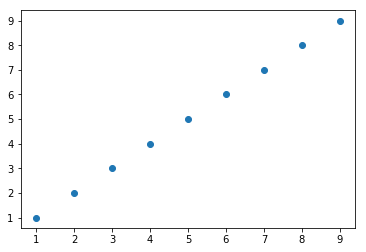

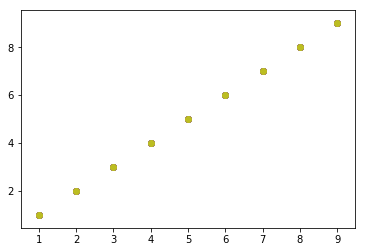

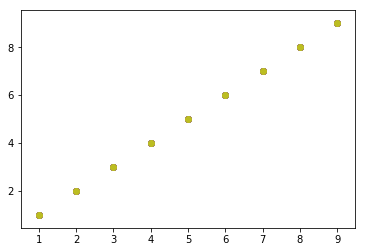

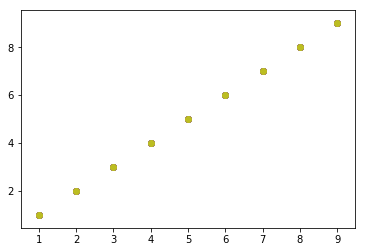

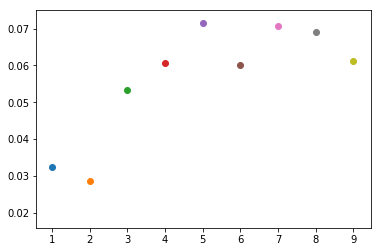

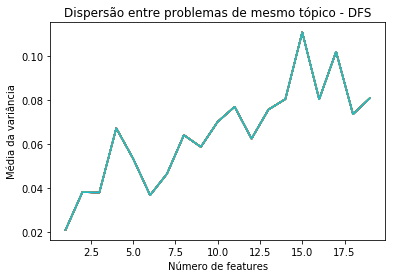

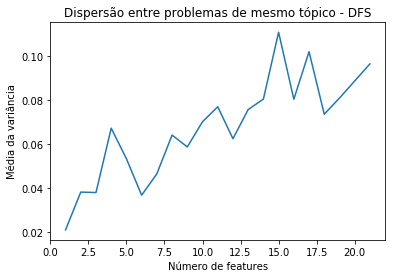

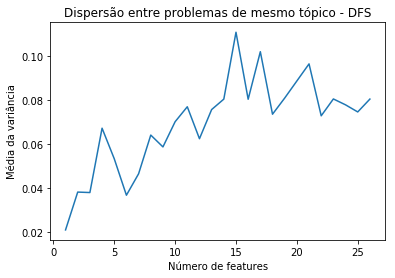

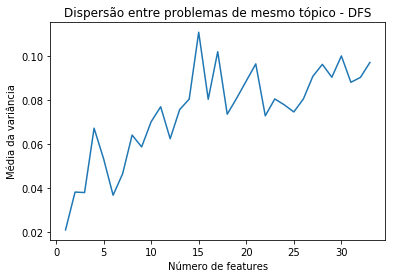

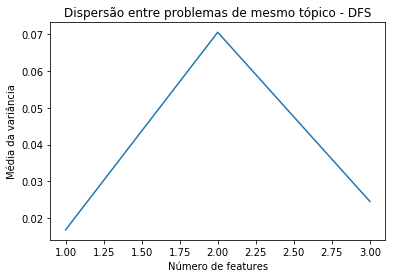

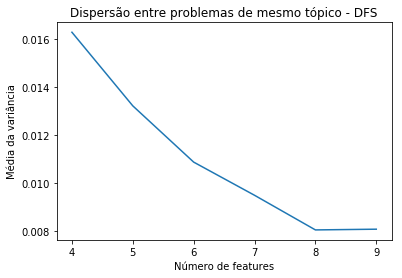

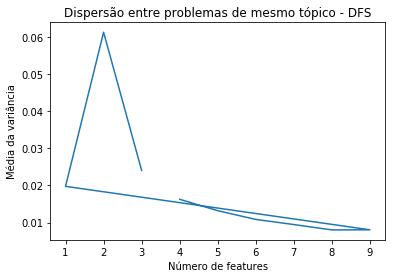

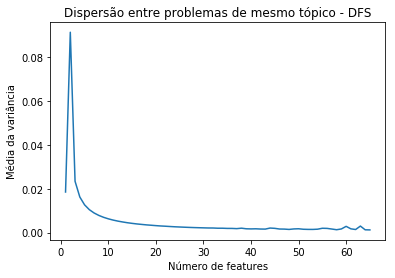

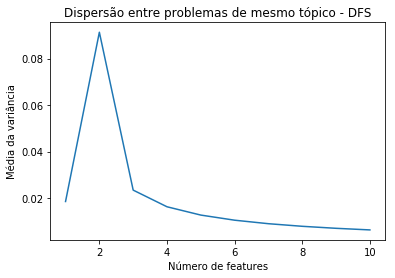

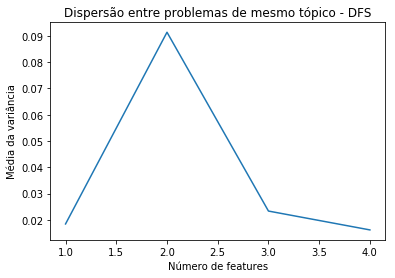

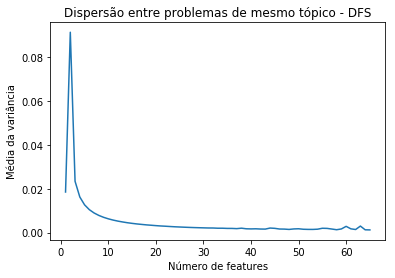

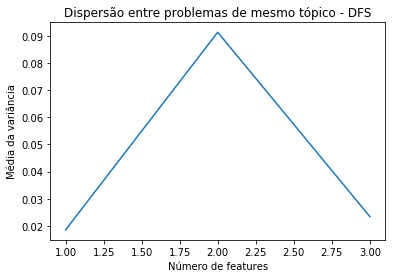

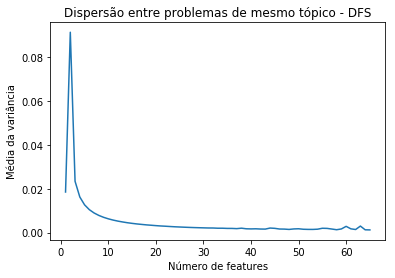

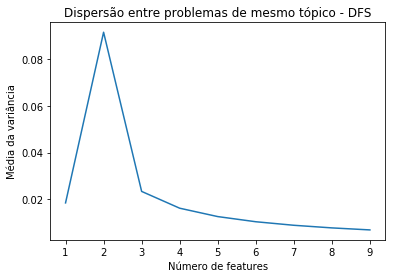

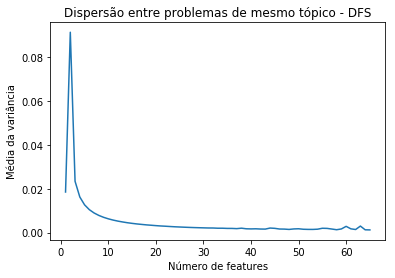

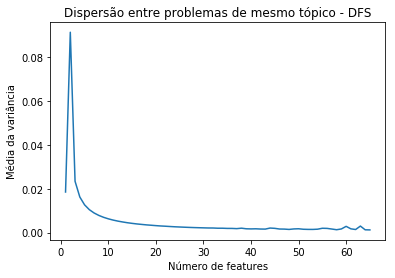

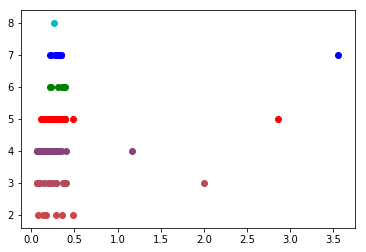

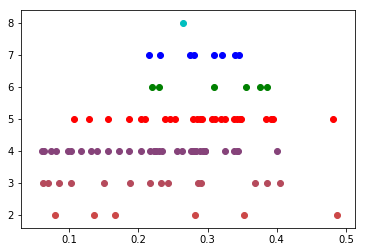

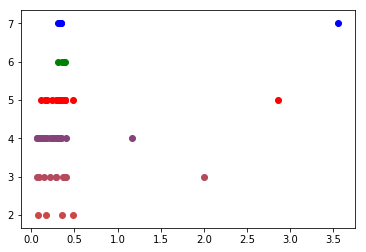

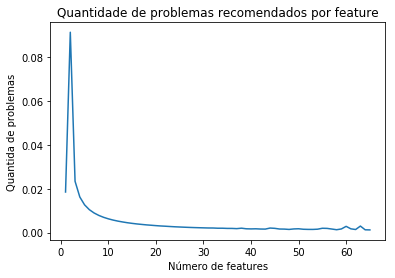

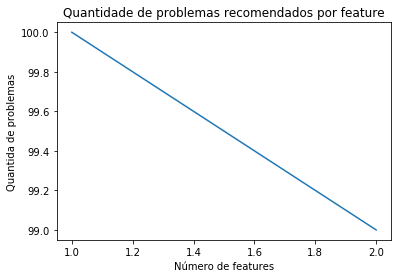

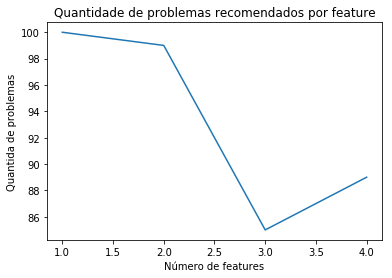

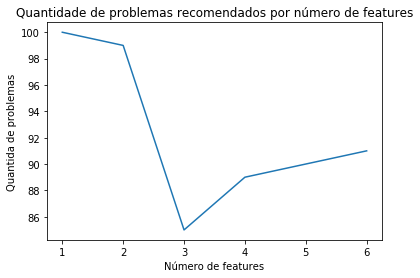

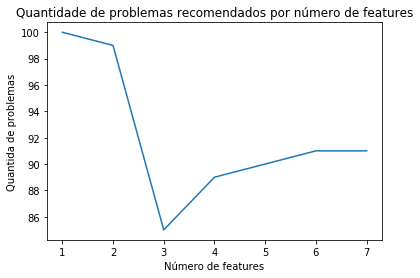

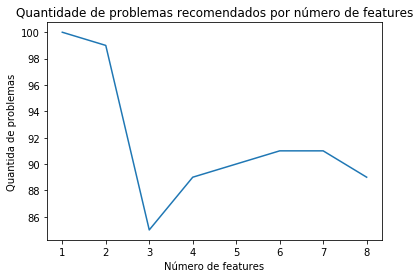

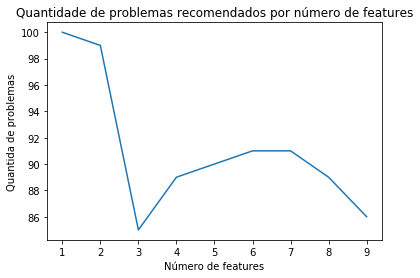

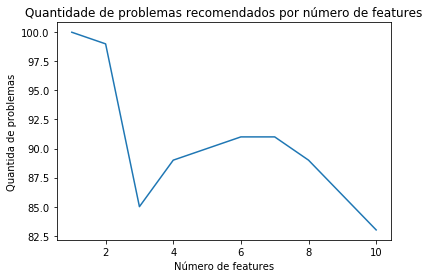

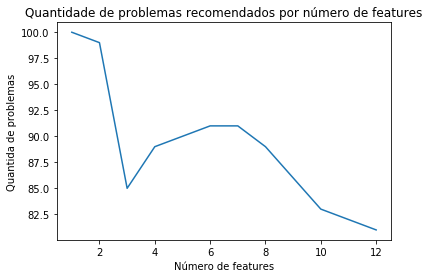

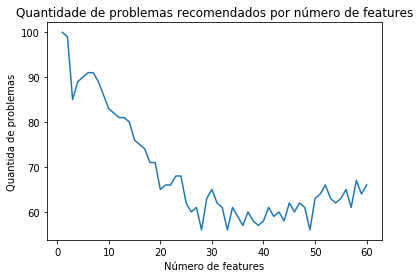

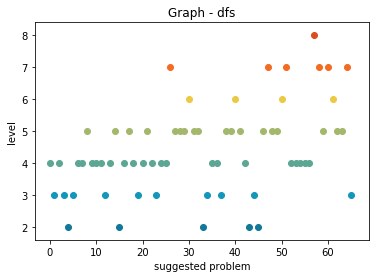

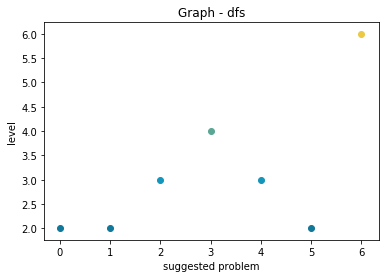

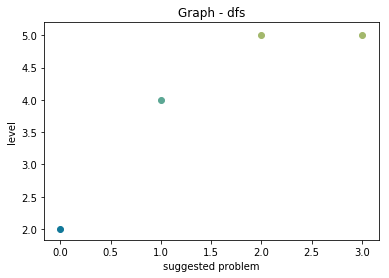

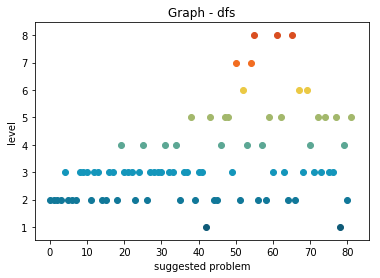

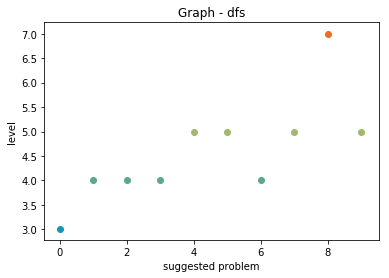

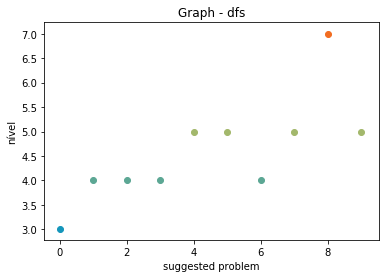

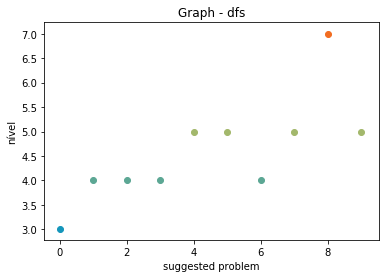

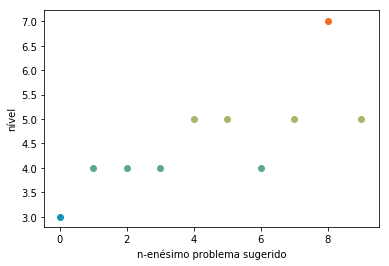

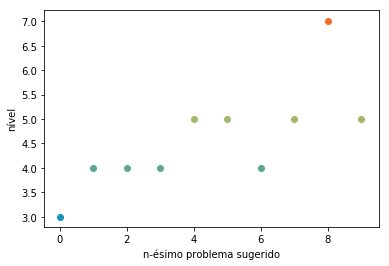

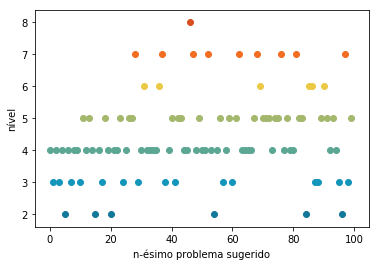

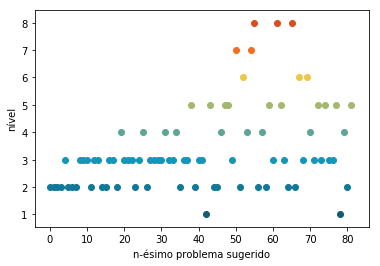

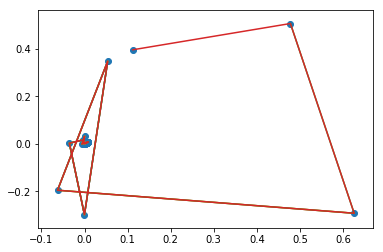

In [601]:
problems_df = get_problems_from_thetas(thetas)
fig = plt.figure()

lx = []
ly = []
lc = []

colors = [
    'black',
    '#17ce31',
    '#1ece17',
    '#6ace17',
    
    '#8cce17',
    '#a6ce17',
    '#ceb317',
    
    '#ce7817',
    '#ce4e17',
    '#ce2317',
]

for problem in thetas.keys():
    x, y = thetas[problem][:2]
    
    lx.append(x)
    ly.append(y)
#     lc.append(colors[problems_df[problems_df['problem_id'] == problem]['level'].values[0]])

plt.scatter(lx, ly)

lx = []
ly = []

for problem in problems_solved:
    x, y = thetas[problem][:2]
    
    lx.append(x)
    ly.append(y)

    plt.plot(lx, ly)

plt.show()

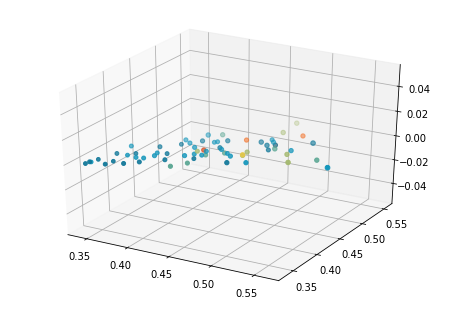

In [174]:
problems_df = get_problems_from_thetas(thetas)
fig = plt.figure()
ax = Axes3D(fig)

lx = []
ly = []
lz = []
lc = []


# for problem in problems_solved:
#     x, y, z = thetas[problem]
    
#     lx.append(x)
#     ly.append(y)
#     lz.append(z)

# plt.plot(lx, ly, lz)

for problem in thetas.keys():
    x, y, z = thetas[problem]
    
    lx.append(x)
    ly.append(y)
    lz.append(z*40)
    
    lc.append(colors[problems_df[problems_df['problem_id'] == problem]['level'].values[0]])

plt.scatter(lx, ly, lz, c=lc)
plt.show()

# Ordem crescente de dificuldade

Progress: 98.78048780487805%


/home/saulo/.virtualenvs/bang-recommender-system/local/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


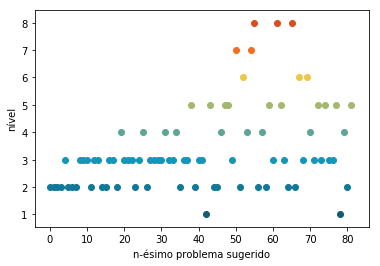

In [593]:
thetas = get_thetas(solutions_df)
problems_solved = simulate_user(thetas)
problems_solved_df = add_theta_to_dataset(problems_solved, thetas)

fig = plt.figure()
for i, problem in enumerate(problems_solved):
    x = i
    y = round(problems_solved_df[problems_solved_df['problem_id'] == problem]['level'].values[0])
    c = COLORS[y]
    plt.scatter(x, y, c=c)


plt.title('')
plt.xlabel('n-ésimo problema sugerido')
plt.ylabel('nível')

fig

/home/saulo/.virtualenvs/bang-recommender-system/local/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


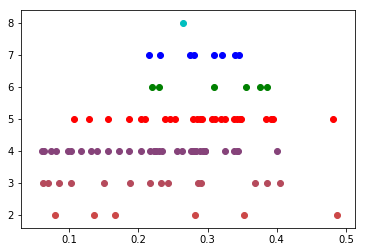

In [513]:
problems_df = get_problems_from_thetas(thetas)
problems_df

colors = [
    '#ffbc00',
    '#ea802e',
    '#cc4848',
    '#b54a5c',
    '#86437a',
    'r',
    'g',
    'b',
    'c',
]

x, y = list(problems_df['theta']), list(problems_df['level'])
fig = plt.figure()
for i in range(len(x)):
    if x[i] > 0.5:
        continue
    plt.scatter(x[i], y[i], c=colors[y[i]])
#     plt.text(x*1.02, y*1.02, label, fontsize=12)
fig

In [514]:
problems_solved_df = add_theta_to_dataset(problems_solved, thetas)
problems_solved_df

,problem_id,category_id,level,solved,name,topics,theta
81,1082,7,4,1766,Connected Components,"dfs, backtracking",0.060661
194,1195,7,4,1863,Binary Search Tree,"binary search tree, pre, in, post order",0.063322
147,1148,7,3,2056,Countries at War,"graph, dijkstra",0.069303
854,1855,7,2,1351,Maester's Map,graph traversal,0.078971
199,1200,7,4,864,BST Operations I,binary search tree,0.081358
151,1152,7,3,2219,Dark Roads,"graph, mst, kruskal",0.085571
99,1100,7,4,1102,Knight Moves,"graph theory, flood fill, bellman-ford or floy...",0.098967
190,1191,7,4,1159,Tree Recovery,"binary tree, recursivity",0.102610
127,1128,7,5,1351,Come and Go,"graphs, tarjan's strongly connected components...",0.107540
465,1466,7,4,709,Level Order Tree Traversal,"binary search tree, level order tree",0.117730


/home/saulo/.virtualenvs/bang-recommender-system/local/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


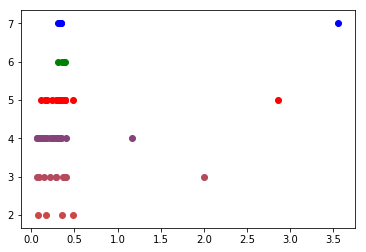

In [515]:
colors = [
    '#ffbc00',
    '#ea802e',
    '#cc4848',
    '#b54a5c',
    '#86437a',
    'r',
    'g',
    'b',
    'c',
]

x, y,z  = list(problems_solved_df['theta']), list(problems_solved_df['level']), list(problems_solved_df['level'])
fig = plt.figure()
for i in range(len(x)):
    plt.scatter(x[i], y[i], c=colors[z[i]])
#     plt.text(x*1.02, y*1.02, label, fontsize=12)
fig

# Quantidade de Problemas

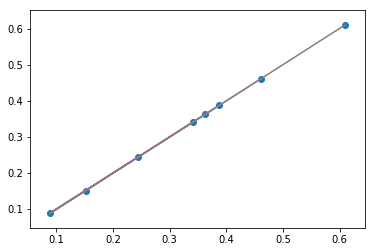

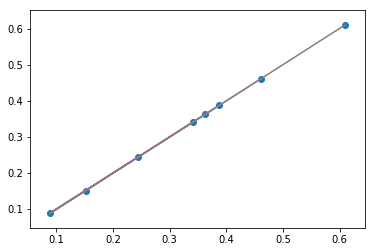

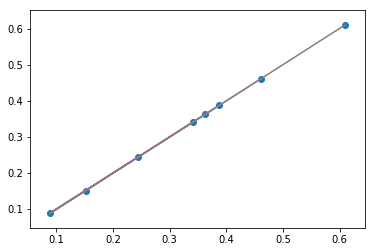

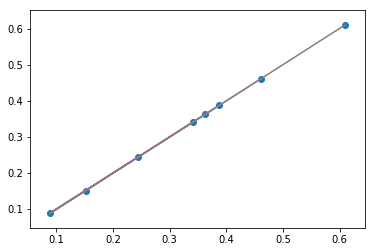

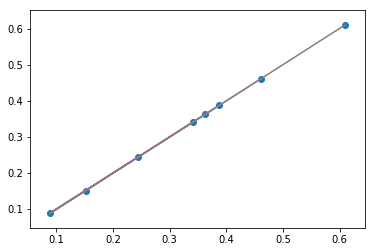

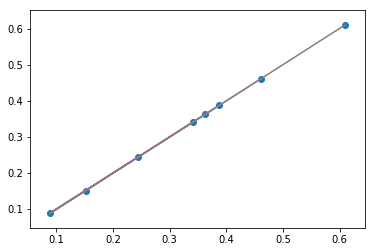

In [436]:
# thetas = get_thetas(solutions_df)
problems_df = get_problems_from_thetas(thetas)
fig = plt.figure()

lx = []
ly = []
lc = []

for problem in thetas.keys():
    x, y = thetas[problem][:2]
    
    lx.append(x)
    ly.append(y)
#     lc.append(colors[problems_df[problems_df['problem_id'] == problem]['level'].values[0]])

plt.scatter(lx, ly)

lx = []
ly = []

for problem in problems_solved:
    x, y = thetas[problem][:2]
    
    lx.append(x)
    ly.append(y)

    plt.plot(lx, ly)

plt.show()

# Problemas semelhantes

/home/saulo/.virtualenvs/bang-recommender-system/local/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


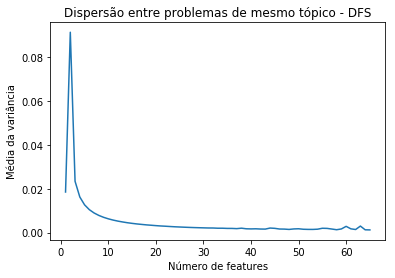

In [496]:
dfs_problems = [1706, 1469, 1907, 1322]
# solutions_df = load_solutions()

# vs = []
# fs = []

# for nr_features in range(1,100):
#     NR_FEATURES = nr_features    
#     thetas = get_thetas(solutions_df)
#     selected_thetas = [thetas[t] for t in dfs_problems]
#     variance = np.array(selected_thetas).std(axis=0).mean()

#     vs.append(variance)
#     fs.append(nr_features)
#     print(nr_features)

fig = plt.figure()
plt.plot(fs, vs)
plt.title('Dispersão entre problemas de mesmo tópico - DFS')
plt.ylabel('Média da variância')
plt.xlabel('Número de features')
fig

Progress: 99.0%


/home/saulo/.virtualenvs/bang-recommender-system/local/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


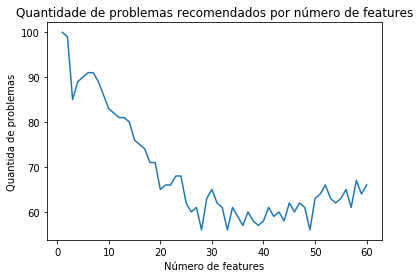

In [525]:
# xs = []
# ys = []

for i in range(13, 61):
    NR_FEATURES = i
    thetas = get_thetas(solutions_df)
    problems_solved = simulate_user(thetas)
    
    xs.append(i)
    ys.append(len(problems_solved))
    

fig = plt.figure()
plt.plot(xs, ys)
plt.title('Quantidade de problemas recomendados por número de features')
plt.ylabel('Quantida de problemas')
plt.xlabel('Número de features')
fig

In [511]:
problems_solved = simulate_user(thetas)

In [ ]:
def load_result(filename):
    data = np.load(filename).item()
    return data

In [ ]:
def simulate():
    solutions_df = load_solutions()
    thetas = get_thetas(solutions_df)
    problems_solved = simulate_user(thetas)
    save_result(problems_solved)

In [ ]:
#for j in range(100, 600, 100): # nr_iterations
#for k in range(1, 20): # epochs
NR_EPOCHS = 100
NR_ITERATIONS = 100
    
for i in range(6, 9): # category
        for l in range(1, 20): #features
            NR_FEATURES = l
            CATEGORY = i # i

            simulate()

In [ ]:
NR_FEATURES = 4
NR_EPOCHS = 10
NR_ITERATIONS = 100
CATEGORY = 7

simulate()

In [ ]:
#desenvolver gráfico com level, solucoes, id, submissoes
#verificar se a sequencia com 10 epocas esta dentro das sugestoes com 16 epocas (4,8,16,32)